# 1. Model Selection

The aim of hyperparameter tuning for model selection is to improve the model’s generalisation performance by finding the hyperparameter values that provide the best out-of-sample performance.

## 1.1. GridSearchCV

To estimate the generalisation performance, we analyse the performance of each hyperparameter combination using cross-validation, also known as cross-validated
grid search (GridSearchCV). The estimators `RFECV_ESTS` and the parameter grids `param_grid` are specified in `predict/parameters.py`.

In [1]:
%reset -f


#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_02_fs_rfe_mask.pkl")

warnings.simplefilter(action="default")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import GridSearchCV
from predict import visualise

PARALLEL = False
grid = {}

if PARALLEL:
    print(colored("Parallel Computation", "red"))
# display pipeline
set_config(display="diagram")
for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    grid[cat] = {}
    
    for e_ind, est in enumerate(RFECV_ESTS): # the mlp one will try both solvers
        
        pipe.steps.pop(-1) # pop "eval"
        pipe.steps.pop(-1) # pop "rfe_mask_fs"

        evaluate = (
            est
            if not isinstance(est, eli5.sklearn.PermutationImportance)
            else est.estimator
        )
        
        print("Regressor:", colored(visualise.get_estimator_label(est), "green")) 

        pipe.steps.extend([
            ("rfe_mask_fs", feature_select.MaskFeatureSelect(rfe_manual_mask[cat][e_ind])),
            ("eval", evaluate)
        ])

        #display(pipe)
        print("Pipeline Steps: " + str(list(pipe.named_steps)))
        
        #####
        # Grid Search CV
        grid[cat][e_ind] = GridSearchCV(
            pipe,
            param_grid=param_grid[e_ind],
            scoring=[GRIDCV_SCORING, "r2"],
            n_jobs= GRIDCV_N_JOBS if PARALLEL else None,
            cv=k_fold,
            # for multi-metric evaluation, refit should be the scorer to be used for best_params_, etc
            refit=GRIDCV_SCORING, # refit=True,
            verbose=True,
            return_train_score = True 
        )

        # fit
        grid[cat][e_ind].fit(train_X_df[cat], train_y_df[cat])

        print("check rfe_mask_fs support mask:\n", grid[cat][e_ind].best_estimator_["rfe_mask_fs"].get_support())
        print(
            "Best cross-validation MAE: {:.4f}".format(-grid[cat][e_ind].best_score_)
        )
        # because it has been refit before, we can get score on the test too
        print(
            "Best MAE on Test: {:.4f}".format(
                -grid[cat][e_ind].score(test_X_df[cat], test_y_df[cat])
            )
        )
        print("Best parameters: {}\n".format(grid[cat][e_ind].best_params_))

        # # check scores: this is just to double check
        # print(colored("Scores of the best on the Test:", "green"))
        # model_regress.check_scores(
        #     grid[cat][e_ind].best_estimator_,
        #     train_X_df[cat],
        #     train_y_df[cat],
        #     test_X_df[cat],
        #     test_y_df[cat],
        #     None,
        # )

display(pipe)

#####
# save the notebook session
dill.dump_session("pickles/regress_03_gridcv.pkl")



***** FP_rate *****
Regressor: MultiTaskElasticNet
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   34.7s finished
check rfe_mask_fs support mask:
 [True, True, True, True, True, False, False, True, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False]
Best cross-validation MAE: 15.7006
Best MAE on Test: 14.8159
Best parameters: {'eval__regressor__alpha': 0.0001, 'eval__regressor__l1_ratio': 1, 'eval__regressor__max_iter': 5000}

Regressor: DecisionTreeRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=1)]: U

Pipeline(steps=[('transform_X',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_trans_feat',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['cpus', 'mem_kb',
                                                   'threads_or_copies'])])),
                ('reorder_X',
                 ColumnReorder(initial_features=['nominal_mhz', 'max_mhz',
                                                 'cpus', 'threads_per_core',
                                                 'cores_per_socket', 'sockets',
                                                 'numas', 'l1d_cache_kb',
                                                 'l1i_cache_kb', 'l...
                ('rfe_mask_fs',
                 MaskFeatureSelect(mask=array([False,  True,  True,  True,  True, False, False, False,  True,
        True, False, False, False, False,  True, False, False, False,
        True,  True,  True, False, False, False]))),
                ('eval',
                 CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                                         hidden_layer_sizes=(20,),
                                                                         max_iter=10000,
                                                                         random_state=42,
                                                                         solver='lbfgs',
                                                                         tol=0.001),
                                                  trans_y='log'))])

## 1.2 Exploring GridSearchCV Results

Model Selection: For each estimator, we select its top-10 models with the highest predictive power, i.e. with the best average GridSearchCV scores, and then compare them together in terms of the prediction error and latency.

In [1]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_03_gridcv.pkl")

warnings.simplefilter(action="default")

pd.set_option("display.max_columns", None)  # show all columns when display
pd.set_option("display.max_rows", None)

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))
    for e_ind, est in enumerate(RFECV_ESTS):
        
        # print(colored("Scores of the best on the Test:", "green"))
        # model_regress.check_scores(
        #     grid[cat][e_ind].best_estimator_,
        #     train_X_df[cat],
        #     train_y_df[cat],
        #     test_X_df[cat],
        #     test_y_df[cat],
        #     None,
        # )
        print("GridSearchCV Regressor:", colored(visualise.get_estimator_label(est), "green")) 

        gs_df = pd.concat(
            [pd.DataFrame(grid[cat][e_ind].cv_results_["params"]),
            # use "mean_test_score" for single metric evaluation
            pd.DataFrame(grid[cat][e_ind].cv_results_["mean_train_r2"], columns=["Avg. CV Train R2"]),
            pd.DataFrame(grid[cat][e_ind].cv_results_["mean_test_r2"], columns=["Avg. CV Test R2"]),
            pd.DataFrame(-grid[cat][e_ind].cv_results_["mean_train_neg_mean_absolute_error"], columns=["Avg. CV Train MAE"]),
            pd.DataFrame(-grid[cat][e_ind].cv_results_["mean_test_neg_mean_absolute_error"], columns=["Avg. CV Test MAE"]),
            pd.DataFrame(grid[cat][e_ind].cv_results_["mean_score_time"], columns=["mean score time"]),
            pd.DataFrame(grid[cat][e_ind].cv_results_["mean_fit_time"], columns=["mean fit time"])
            ],
            axis=1)
        gs_df = gs_df.sort_values(by=['Avg. CV Test MAE'], ascending=True)
        
        # style the dateframe
        def f(dat, c="green"):
            return [f'background-color: {c}' for i in dat]

        display(gs_df.head(15).style.apply(f, axis=0, subset=["Avg. CV Test MAE", "mean score time"]))
        regr_model = model_regress.RegrModel("grid_best regr_model", grid[cat][e_ind].best_estimator_)

        # regr_model.fit(train_X_df[cat], train_y_df[cat])
        # regr_model.predict(test_X_df[cat], test_y_df[cat])
        # print(regr_model)
    

/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.ut


***** FP_rate *****
GridSearchCV Regressor: MultiTaskElasticNet


,eval__regressor__alpha,eval__regressor__l1_ratio,eval__regressor__max_iter,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
3,0.000100,1.000000,5000,0.973407,0.972228,15.640240,15.700605,0.014750,0.888635
2,0.000100,0.750000,5000,0.973407,0.972224,15.650735,15.711290,0.013280,0.856410
1,0.000100,0.500000,5000,0.973408,0.972221,15.661172,15.721903,0.013148,0.900876
0,0.000100,0.250000,5000,0.973408,0.972218,15.671549,15.732437,0.012141,1.119168
7,0.001000,1.000000,5000,0.973505,0.972267,16.101715,16.163832,0.012681,0.403362
6,0.001000,0.750000,5000,0.973489,0.972214,16.202402,16.264869,0.012823,0.412983
5,0.001000,0.500000,5000,0.973474,0.972162,16.293071,16.355501,0.013017,0.493683
4,0.001000,0.250000,5000,0.973460,0.972112,16.374534,16.437057,0.012858,0.517710
8,0.010000,0.250000,5000,0.969757,0.967365,20.182656,20.250135,0.011737,0.123348
9,0.010000,0.500000,5000,0.969891,0.967544,20.355593,20.422014,0.011662,0.117737


GridSearchCV Regressor: DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
4,mse,25.000000,0.999850,0.931408,0.351373,10.034477,0.006391,0.039393
5,mse,nan,0.999850,0.931408,0.351373,10.034477,0.006292,0.037688
3,mse,20.000000,0.999843,0.926552,0.394960,10.138551,0.006466,0.039431
2,mse,15.000000,0.999455,0.927501,1.533417,10.327991,0.006205,0.036578
14,mae,15.000000,0.999291,0.925433,1.374623,10.495770,0.005380,3.684792
15,mae,20.000000,0.999826,0.923790,0.385135,10.508179,0.005211,3.574786
16,mae,25.000000,0.999845,0.923358,0.339583,10.527767,0.005026,3.452401
17,mae,nan,0.999845,0.923358,0.339375,10.527896,0.004957,3.449849
10,friedman_mse,25.000000,0.999849,0.923811,0.354950,10.942680,0.005866,0.037291
11,friedman_mse,nan,0.999850,0.922980,0.351373,11.006965,0.006770,0.036500


GridSearchCV Regressor: RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
29,0.700000,nan,200,0.994181,0.936162,4.073767,10.963333,0.040620,1.422701
28,0.700000,nan,100,0.993573,0.936014,4.121959,10.987925,0.022543,0.718948
44,0.900000,nan,200,0.994028,0.936120,4.075111,10.992613,0.040815,1.636662
43,0.900000,nan,100,0.993351,0.935889,4.127194,11.011627,0.022625,0.827795
59,nan,nan,200,0.994361,0.936018,4.072503,11.036535,0.041029,1.770621
27,0.700000,nan,50,0.994249,0.935825,4.158626,11.038858,0.014048,0.365401
13,0.500000,nan,100,0.992738,0.935659,4.167653,11.065313,0.023334,0.633619
24,0.700000,0.900000,200,0.992605,0.936377,4.499753,11.068109,0.039596,1.359040
14,0.500000,nan,200,0.994008,0.935227,4.101289,11.069033,0.040838,1.231761
58,nan,nan,100,0.993621,0.935753,4.114195,11.070916,0.022946,0.894311


GridSearchCV Regressor: Permutation_DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
4,mse,25.000000,0.999846,0.930330,0.358172,10.045086,0.005120,0.030299
5,mse,nan,0.999846,0.930340,0.357578,10.050708,0.004922,0.029474
2,mse,15.000000,0.999417,0.928888,1.624166,10.131038,0.004882,0.028856
3,mse,20.000000,0.999835,0.929808,0.423166,10.142144,0.006095,0.033308
14,mae,15.000000,0.999295,0.930003,1.343391,10.395584,0.004996,3.502663
17,mae,nan,0.999840,0.926055,0.344757,10.478746,0.004968,3.496841
15,mae,20.000000,0.999828,0.925722,0.379146,10.522182,0.005074,3.507614
16,mae,25.000000,0.999840,0.925306,0.345301,10.544626,0.005042,3.497801
9,friedman_mse,20.000000,0.999789,0.925645,0.523017,10.810624,0.004960,0.029743
10,friedman_mse,25.000000,0.999846,0.925447,0.358735,10.816243,0.004984,0.029727


GridSearchCV Regressor: Permutation_RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
29,0.700000,nan,200,0.994598,0.937634,3.288335,9.093146,0.040247,1.531003
14,0.500000,nan,200,0.994697,0.938161,3.309549,9.120462,0.040201,1.306798
23,0.700000,0.900000,100,0.992489,0.939089,3.687695,9.124237,0.022564,0.725211
28,0.700000,nan,100,0.993754,0.937619,3.346294,9.128185,0.022662,0.762434
24,0.700000,0.900000,200,0.993240,0.938597,3.644682,9.130925,0.039710,1.457571
44,0.900000,nan,200,0.994731,0.938501,3.313781,9.133669,0.040462,1.756349
13,0.500000,nan,100,0.993940,0.938210,3.365024,9.153705,0.022604,0.652638
43,0.900000,nan,100,0.993748,0.938291,3.380102,9.177530,0.022496,0.880859
59,nan,nan,200,0.994813,0.938383,3.327863,9.191237,0.040401,1.871488
42,0.900000,nan,50,0.994325,0.938287,3.417255,9.211792,0.014691,0.454662


GridSearchCV Regressor: Permutation_MLPRegressor_adam


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__early_stopping,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
6,tanh,0.000010,True,"(50,)",adam,0.000500,0.944691,0.891652,23.558661,25.073685,0.009879,0.911757
14,tanh,0.000100,True,"(50,)",adam,0.000500,0.944691,0.891652,23.558658,25.073686,0.011434,0.910471
22,tanh,0.001000,True,"(50,)",adam,0.000500,0.944691,0.891650,23.558628,25.073695,0.012512,0.913389
30,tanh,0.010000,True,"(50,)",adam,0.000500,0.944691,0.891629,23.558342,25.073789,0.009942,0.933390
4,tanh,0.000010,True,"(30,)",adam,0.000500,0.930151,0.864274,25.633747,27.167132,0.008453,0.951131
12,tanh,0.000100,True,"(30,)",adam,0.000500,0.930345,0.864404,25.633753,27.168872,0.008376,0.961694
20,tanh,0.001000,True,"(30,)",adam,0.000500,0.928364,0.866534,25.823891,27.354782,0.008352,0.954772
28,tanh,0.010000,True,"(30,)",adam,0.000500,0.928134,0.866308,25.838885,27.380674,0.008387,0.957223
31,tanh,0.010000,True,"(50,)",adam,0.001000,0.931252,0.892323,26.854228,27.934135,0.010052,0.633154
23,tanh,0.001000,True,"(50,)",adam,0.001000,0.931249,0.892315,26.854920,27.934937,0.009942,0.630594


GridSearchCV Regressor: Permutation_MLPRegressor_lbfgs


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
22,tanh,0.001000,"(50,)",lbfgs,0.000500,0.989554,0.924397,10.395658,12.266183,0.022648,21.351161
18,tanh,0.001000,"(20,)",lbfgs,0.000500,0.986135,0.947374,11.103134,12.436253,0.016180,19.216926
30,tanh,0.010000,"(50,)",lbfgs,0.000500,0.989497,0.914629,10.407563,12.488585,0.016995,21.461339
10,tanh,0.000100,"(20,)",lbfgs,0.000500,0.987113,0.946944,11.070189,12.510745,0.016541,17.191330
28,tanh,0.010000,"(30,)",lbfgs,0.000500,0.988136,0.937913,10.800891,12.516097,0.018633,11.234274
26,tanh,0.010000,"(20,)",lbfgs,0.000500,0.985554,0.949060,11.235877,12.589726,0.015613,13.337173
19,tanh,0.001000,"(20,)",lbfgs,0.001000,0.983714,0.953545,11.571550,12.643397,0.016207,7.628027
6,tanh,0.000010,"(50,)",lbfgs,0.000500,0.989403,0.775988,10.429994,12.655638,0.020924,20.841097
31,tanh,0.010000,"(50,)",lbfgs,0.001000,0.988056,0.948875,10.997805,12.692183,0.026801,12.203479
23,tanh,0.001000,"(50,)",lbfgs,0.001000,0.988301,0.943859,10.953616,12.717424,0.018812,12.493924



***** FP_speed *****
GridSearchCV Regressor: MultiTaskElasticNet


,eval__regressor__alpha,eval__regressor__l1_ratio,eval__regressor__max_iter,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
3,0.000100,1.000000,5000,0.896809,0.894931,11.082697,11.137136,0.013103,0.482608
2,0.000100,0.750000,5000,0.896793,0.894915,11.084603,11.139039,0.013555,0.489144
1,0.000100,0.500000,5000,0.896776,0.894898,11.086546,11.140975,0.013412,0.539973
0,0.000100,0.250000,5000,0.896758,0.894880,11.088531,11.142950,0.012413,0.809517
7,0.001000,1.000000,5000,0.896116,0.894232,11.155063,11.210656,0.013062,0.319746
6,0.001000,0.750000,5000,0.895794,0.893909,11.181804,11.237151,0.013050,0.327255
5,0.001000,0.500000,5000,0.895429,0.893542,11.209791,11.265134,0.012955,0.309896
4,0.001000,0.250000,5000,0.895037,0.893147,11.237971,11.293091,0.013125,0.349485
11,0.010000,1.000000,5000,0.871347,0.869329,12.734771,12.789900,0.012133,0.215147
10,0.010000,0.750000,5000,0.869641,0.867601,12.780477,12.836268,0.012293,0.158624


GridSearchCV Regressor: DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
17,mae,nan,0.999333,0.953745,0.202896,5.383203,0.004999,2.154377
16,mae,25.000000,0.999333,0.953745,0.202896,5.383203,0.005044,2.168263
15,mae,20.000000,0.999290,0.953265,0.225571,5.407044,0.005126,2.171830
14,mae,15.000000,0.997265,0.953545,0.717303,5.436774,0.005115,2.196015
3,mse,20.000000,0.999372,0.953213,0.239092,5.510670,0.005560,0.029962
4,mse,25.000000,0.999399,0.952852,0.215745,5.555963,0.005352,0.028813
5,mse,nan,0.999399,0.952787,0.215745,5.559559,0.005408,0.028835
2,mse,15.000000,0.997846,0.953518,0.884069,5.699845,0.006097,0.033990
11,friedman_mse,nan,0.999399,0.945747,0.215745,5.876857,0.005572,0.030770
10,friedman_mse,25.000000,0.999396,0.944963,0.217920,5.939047,0.005349,0.029004


GridSearchCV Regressor: RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
14,0.500000,nan,200,0.995524,0.969199,1.835955,4.752609,0.034350,1.036613
13,0.500000,nan,100,0.995461,0.969236,1.866418,4.780911,0.020637,0.520578
29,0.700000,nan,200,0.995409,0.968730,1.845578,4.786636,0.036047,1.211769
9,0.500000,0.900000,200,0.994697,0.969511,2.017387,4.788306,0.034124,0.981449
8,0.500000,0.900000,100,0.994562,0.969459,2.043622,4.799647,0.019892,0.497058
28,0.700000,nan,100,0.995327,0.968800,1.867908,4.808048,0.019610,0.607129
24,0.700000,0.900000,200,0.994568,0.968831,2.027948,4.821615,0.033812,1.142341
12,0.500000,nan,50,0.995288,0.968862,1.898001,4.829806,0.012418,0.268600
7,0.500000,0.900000,50,0.994322,0.969401,2.087637,4.837937,0.012445,0.260930
27,0.700000,nan,50,0.995148,0.968818,1.897980,4.842002,0.012229,0.306783


GridSearchCV Regressor: Permutation_DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
15,mae,20.000000,0.999278,0.951425,0.230990,5.465171,0.004904,2.029231
17,mae,nan,0.999339,0.950912,0.200054,5.483287,0.004819,1.997852
5,mse,nan,0.999405,0.954326,0.212902,5.512359,0.005376,0.024961
16,mae,25.000000,0.999339,0.950610,0.200054,5.515952,0.004851,2.010448
4,mse,25.000000,0.999405,0.954185,0.213559,5.520232,0.004755,0.024688
3,mse,20.000000,0.999356,0.952907,0.244191,5.576220,0.004899,0.025393
14,mae,15.000000,0.996327,0.951845,0.832595,5.632654,0.004916,2.021178
2,mse,15.000000,0.997385,0.953813,0.963371,5.699475,0.005398,0.026378
9,friedman_mse,20.000000,0.999166,0.946095,0.302503,5.891701,0.004841,0.025138
11,friedman_mse,nan,0.999405,0.945994,0.212902,5.910995,0.005234,0.024929


GridSearchCV Regressor: Permutation_RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
14,0.500000,nan,200,0.995524,0.969199,1.835955,4.752609,0.035833,1.054059
13,0.500000,nan,100,0.995461,0.969236,1.866418,4.780911,0.019444,0.516348
29,0.700000,nan,200,0.995409,0.968730,1.845578,4.786636,0.035407,1.200977
9,0.500000,0.900000,200,0.994697,0.969511,2.017387,4.788306,0.033949,0.976294
8,0.500000,0.900000,100,0.994562,0.969459,2.043622,4.799647,0.019414,0.495785
28,0.700000,nan,100,0.995327,0.968800,1.867908,4.808048,0.019720,0.614737
24,0.700000,0.900000,200,0.994568,0.968831,2.027948,4.821615,0.033516,1.136088
12,0.500000,nan,50,0.995288,0.968862,1.898001,4.829806,0.012147,0.263512
7,0.500000,0.900000,50,0.994322,0.969401,2.087637,4.837937,0.012334,0.253718
27,0.700000,nan,50,0.995148,0.968818,1.897980,4.842002,0.012737,0.309531


GridSearchCV Regressor: Permutation_MLPRegressor_adam


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__early_stopping,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
6,tanh,0.000010,True,"(50,)",adam,0.000500,0.882090,0.880373,13.454733,13.522643,0.009081,1.399679
14,tanh,0.000100,True,"(50,)",adam,0.000500,0.882090,0.880373,13.454735,13.522645,0.009064,1.413191
22,tanh,0.001000,True,"(50,)",adam,0.000500,0.882089,0.880372,13.454754,13.522658,0.009224,1.403503
30,tanh,0.010000,True,"(50,)",adam,0.000500,0.882076,0.880363,13.454958,13.522801,0.009272,1.410477
46,relu,0.000100,True,"(50,)",adam,0.000500,0.883123,0.876761,13.539840,13.753976,0.008018,1.624966
38,relu,0.000010,True,"(50,)",adam,0.000500,0.882948,0.876981,13.559646,13.771793,0.007727,1.610879
54,relu,0.001000,True,"(50,)",adam,0.000500,0.882956,0.876980,13.561407,13.773641,0.007622,1.607614
62,relu,0.010000,True,"(50,)",adam,0.000500,0.882951,0.876995,13.563218,13.775578,0.007605,1.605912
4,tanh,0.000010,True,"(30,)",adam,0.000500,0.867689,0.865353,14.176482,14.275946,0.005054,1.088996
12,tanh,0.000100,True,"(30,)",adam,0.000500,0.867689,0.865352,14.176485,14.275949,0.005081,1.098605


GridSearchCV Regressor: Permutation_MLPRegressor_lbfgs


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
46,relu,0.000100,"(50,)",lbfgs,0.000500,0.965136,0.953147,6.361421,6.851655,0.015675,17.928484
54,relu,0.001000,"(50,)",lbfgs,0.000500,0.965535,0.938164,6.310830,6.869944,0.014644,18.126454
62,relu,0.010000,"(50,)",lbfgs,0.000500,0.963702,0.950487,6.459147,6.925499,0.017855,10.407907
38,relu,0.000010,"(50,)",lbfgs,0.000500,0.965335,0.938620,6.340626,6.992044,0.015588,17.658838
22,tanh,0.001000,"(50,)",lbfgs,0.000500,0.962258,0.952945,6.575373,7.000220,0.019944,16.886759
30,tanh,0.010000,"(50,)",lbfgs,0.000500,0.962376,0.954403,6.578568,7.006417,0.018579,16.505014
6,tanh,0.000010,"(50,)",lbfgs,0.000500,0.962211,0.953591,6.592161,7.016074,0.016262,15.635278
14,tanh,0.000100,"(50,)",lbfgs,0.000500,0.962272,0.952487,6.607734,7.035397,0.020570,15.698487
55,relu,0.001000,"(50,)",lbfgs,0.001000,0.960041,0.948324,6.753280,7.120247,0.018088,6.227752
63,relu,0.010000,"(50,)",lbfgs,0.001000,0.959739,0.948901,6.746052,7.144621,0.017139,5.779046



***** Int_rate *****
GridSearchCV Regressor: MultiTaskElasticNet


,eval__regressor__alpha,eval__regressor__l1_ratio,eval__regressor__max_iter,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
3,0.000100,1.000000,5000,0.989955,0.989352,10.760676,10.815326,0.013708,0.917291
2,0.000100,0.750000,5000,0.989964,0.989362,10.760844,10.815586,0.013804,1.006911
1,0.000100,0.500000,5000,0.989974,0.989372,10.761023,10.815851,0.013907,1.140933
0,0.000100,0.250000,5000,0.989983,0.989382,10.761214,10.816166,0.014107,1.536523
4,0.001000,0.250000,5000,0.990189,0.989623,10.841562,10.897648,0.013479,0.495447
5,0.001000,0.500000,5000,0.990092,0.989526,10.844298,10.899625,0.013418,0.405574
6,0.001000,0.750000,5000,0.989987,0.989422,10.849169,10.903531,0.013076,0.372368
7,0.001000,1.000000,5000,0.989875,0.989311,10.856654,10.910141,0.012788,0.355112
11,0.010000,1.000000,5000,0.989258,0.988700,11.609516,11.650154,0.013057,0.068853
10,0.010000,0.750000,5000,0.989530,0.989017,11.687765,11.734757,0.013046,0.069973


GridSearchCV Regressor: DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
17,mae,nan,0.999935,0.984328,0.350718,7.334829,0.005113,2.665837
16,mae,25.000000,0.999935,0.976454,0.350754,7.474253,0.005110,2.695394
15,mae,20.000000,0.999928,0.976041,0.388079,7.542714,0.005513,2.849905
3,mse,20.000000,0.999935,0.977474,0.393914,7.610770,0.006188,0.035999
4,mse,25.000000,0.999939,0.974950,0.365450,7.639557,0.006672,0.039844
5,mse,nan,0.999939,0.974950,0.365450,7.639557,0.006202,0.036820
14,mae,15.000000,0.999781,0.969556,0.936036,7.705748,0.005618,2.890481
2,mse,15.000000,0.999791,0.973646,1.073491,7.735844,0.006084,0.035414
9,friedman_mse,20.000000,0.999926,0.977385,0.432355,8.089829,0.006050,0.035607
10,friedman_mse,25.000000,0.999939,0.973481,0.365510,8.246232,0.006122,0.035747


GridSearchCV Regressor: RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
44,0.900000,nan,200,0.992981,0.978973,4.653504,7.110360,0.035683,1.167308
29,0.700000,nan,200,0.992607,0.978783,4.668992,7.111579,0.035530,1.024076
43,0.900000,nan,100,0.993103,0.978617,4.665805,7.126632,0.020122,0.583561
28,0.700000,nan,100,0.992468,0.978402,4.692528,7.144650,0.020478,0.520590
26,0.700000,nan,30,0.992376,0.980120,4.738250,7.150486,0.009595,0.168241
59,nan,nan,200,0.992834,0.978865,4.676376,7.155322,0.036087,1.221316
42,0.900000,nan,50,0.993325,0.978003,4.669310,7.160446,0.012499,0.300467
58,nan,nan,100,0.992528,0.977782,4.698641,7.175623,0.020093,0.617324
39,0.900000,0.900000,200,0.991079,0.977534,4.813317,7.185453,0.035153,1.104607
38,0.900000,0.900000,100,0.991019,0.977625,4.836891,7.185466,0.020101,0.557147


GridSearchCV Regressor: Permutation_DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
17,mae,nan,0.999935,0.979225,0.350130,7.303864,0.005001,2.724537
14,mae,15.000000,0.999774,0.983992,0.956371,7.362887,0.005381,2.892925
4,mse,25.000000,0.999939,0.978906,0.364861,7.483880,0.004913,0.029024
5,mse,nan,0.999939,0.978906,0.364861,7.483880,0.004972,0.029593
2,mse,15.000000,0.999789,0.975327,1.083386,7.589464,0.005670,0.032152
16,mae,25.000000,0.999935,0.959358,0.350303,7.783975,0.004981,2.717204
3,mse,20.000000,0.999935,0.973210,0.395201,7.800982,0.005008,0.029735
9,friedman_mse,20.000000,0.999926,0.978942,0.433912,7.992835,0.004925,0.029670
10,friedman_mse,25.000000,0.999939,0.976487,0.364922,8.044477,0.004922,0.029430
15,mae,20.000000,0.999928,0.949612,0.387915,8.085221,0.004994,2.751418


GridSearchCV Regressor: Permutation_RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
44,0.900000,nan,200,0.992981,0.978973,4.653504,7.110360,0.036985,1.202615
29,0.700000,nan,200,0.992607,0.978783,4.668992,7.111579,0.037019,1.078526
43,0.900000,nan,100,0.993103,0.978617,4.665805,7.126632,0.021118,0.607244
28,0.700000,nan,100,0.992468,0.978402,4.692528,7.144650,0.021141,0.537408
26,0.700000,nan,30,0.992376,0.980120,4.738250,7.150486,0.009990,0.174621
59,nan,nan,200,0.992834,0.978865,4.676376,7.155322,0.036701,1.278598
42,0.900000,nan,50,0.993325,0.978003,4.669310,7.160446,0.013086,0.311888
58,nan,nan,100,0.992528,0.977782,4.698641,7.175623,0.021114,0.644762
39,0.900000,0.900000,200,0.991079,0.977534,4.813317,7.185453,0.036903,1.149235
38,0.900000,0.900000,100,0.991019,0.977625,4.836891,7.185466,0.020874,0.578968


GridSearchCV Regressor: Permutation_MLPRegressor_adam


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__early_stopping,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
30,tanh,0.010000,True,"(50,)",adam,0.000500,0.965653,0.956319,18.650867,18.995627,0.010685,1.250296
22,tanh,0.001000,True,"(50,)",adam,0.000500,0.965646,0.956301,18.651458,18.997098,0.010805,1.238022
14,tanh,0.000100,True,"(50,)",adam,0.000500,0.965646,0.956299,18.651517,18.997246,0.010442,1.240759
6,tanh,0.000010,True,"(50,)",adam,0.000500,0.965646,0.956299,18.651523,18.997261,0.012482,1.229940
28,tanh,0.010000,True,"(30,)",adam,0.000500,0.946126,0.939469,22.054889,22.322784,0.011335,0.770664
20,tanh,0.001000,True,"(30,)",adam,0.000500,0.946125,0.939471,22.056034,22.323975,0.008857,0.767181
12,tanh,0.000100,True,"(30,)",adam,0.000500,0.946125,0.939471,22.056148,22.324094,0.009323,0.763354
4,tanh,0.000010,True,"(30,)",adam,0.000500,0.946125,0.939471,22.056160,22.324106,0.009887,0.757678
29,tanh,0.010000,True,"(30,)",adam,0.001000,0.929285,0.921041,24.381358,24.685822,0.009388,0.615691
21,tanh,0.001000,True,"(30,)",adam,0.001000,0.929282,0.921039,24.382769,24.687140,0.012194,0.617896


GridSearchCV Regressor: Permutation_MLPRegressor_lbfgs


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
6,tanh,0.000010,"(50,)",lbfgs,0.000500,0.994373,0.990322,8.472168,9.043954,0.018132,9.264995
30,tanh,0.010000,"(50,)",lbfgs,0.000500,0.994366,0.990298,8.472064,9.057800,0.022243,9.290746
22,tanh,0.001000,"(50,)",lbfgs,0.000500,0.994353,0.990417,8.476105,9.068369,0.022978,9.480227
14,tanh,0.000100,"(50,)",lbfgs,0.000500,0.994350,0.990592,8.513714,9.075985,0.020129,8.787168
28,tanh,0.010000,"(30,)",lbfgs,0.000500,0.994141,0.986759,8.563203,9.117053,0.016626,7.126984
4,tanh,0.000010,"(30,)",lbfgs,0.000500,0.994256,0.984408,8.516432,9.140224,0.015397,7.373460
18,tanh,0.001000,"(20,)",lbfgs,0.000500,0.993465,0.990175,8.755342,9.181376,0.018205,5.883791
10,tanh,0.000100,"(20,)",lbfgs,0.000500,0.993228,0.989064,8.824854,9.210651,0.015295,5.164593
20,tanh,0.001000,"(30,)",lbfgs,0.000500,0.994235,0.981574,8.528382,9.214761,0.019007,7.364325
2,tanh,0.000010,"(20,)",lbfgs,0.000500,0.993388,0.989413,8.800628,9.223857,0.015069,4.983439



***** Int_speed *****
GridSearchCV Regressor: MultiTaskElasticNet


,eval__regressor__alpha,eval__regressor__l1_ratio,eval__regressor__max_iter,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
3,0.000100,1.000000,5000,0.888361,0.886483,0.409872,0.411786,0.012827,0.998071
2,0.000100,0.750000,5000,0.888358,0.886480,0.409873,0.411790,0.013132,1.057224
1,0.000100,0.500000,5000,0.888355,0.886476,0.409875,0.411795,0.013748,1.156535
0,0.000100,0.250000,5000,0.888352,0.886473,0.409878,0.411801,0.014087,1.496643
4,0.001000,0.250000,5000,0.886864,0.885097,0.414362,0.416128,0.012852,0.493677
5,0.001000,0.500000,5000,0.886489,0.884734,0.415406,0.417151,0.012711,0.440125
6,0.001000,0.750000,5000,0.885956,0.884215,0.416856,0.418586,0.012537,0.425105
7,0.001000,1.000000,5000,0.885204,0.883478,0.418849,0.420556,0.012541,0.401263
8,0.010000,0.250000,5000,0.881094,0.879495,0.430691,0.432259,0.011212,0.094084
9,0.010000,0.500000,5000,0.879482,0.877915,0.438774,0.440300,0.011376,0.102886


GridSearchCV Regressor: DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
16,mae,25.000000,0.999704,0.963169,0.006125,0.159386,0.005165,2.207746
17,mae,nan,0.999704,0.963052,0.006114,0.159700,0.005113,2.189084
15,mae,20.000000,0.999493,0.962049,0.007770,0.160189,0.005201,2.212321
4,mse,25.000000,0.999718,0.959827,0.006421,0.161538,0.005450,0.030978
5,mse,nan,0.999718,0.959827,0.006421,0.161538,0.005535,0.033035
14,mae,15.000000,0.995958,0.960656,0.028954,0.163172,0.005225,2.238924
3,mse,20.000000,0.999686,0.958336,0.007501,0.164459,0.005695,0.031996
2,mse,15.000000,0.997918,0.958732,0.035585,0.166664,0.006147,0.033262
10,friedman_mse,25.000000,0.999714,0.953638,0.006551,0.180542,0.005494,0.032474
9,friedman_mse,20.000000,0.998856,0.955359,0.014819,0.180591,0.005402,0.031109


GridSearchCV Regressor: RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
44,0.900000,nan,200,0.995090,0.967043,0.061570,0.157464,0.035525,1.458049
59,nan,nan,200,0.995063,0.966821,0.061774,0.157817,0.036422,1.646502
43,0.900000,nan,100,0.994912,0.966857,0.062156,0.157948,0.020112,0.734813
58,nan,nan,100,0.994892,0.966529,0.062365,0.158381,0.020062,0.783666
57,nan,nan,50,0.994430,0.966648,0.063645,0.158861,0.012329,0.390399
29,0.700000,nan,200,0.994910,0.966199,0.062140,0.158960,0.034756,1.264045
42,0.900000,nan,50,0.994545,0.966405,0.063345,0.159164,0.012562,0.371269
28,0.700000,nan,100,0.994752,0.966184,0.062749,0.159304,0.020234,0.638835
27,0.700000,nan,50,0.994384,0.966326,0.063750,0.159883,0.012688,0.321991
54,nan,0.900000,200,0.993952,0.966845,0.068413,0.159963,0.034289,1.463183


GridSearchCV Regressor: Permutation_DecisionTreeRegressor


,eval__regressor__criterion,eval__regressor__max_depth,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
15,mae,20.000000,0.998567,0.959785,0.014919,0.163205,0.005184,2.034358
14,mae,15.000000,0.994896,0.961389,0.034256,0.163858,0.005153,2.048365
3,mse,20.000000,0.998804,0.958932,0.015148,0.164542,0.005818,0.029743
17,mae,nan,0.998790,0.959621,0.013606,0.164559,0.005187,2.021037
5,mse,nan,0.998843,0.959765,0.014285,0.164932,0.005048,0.026474
4,mse,25.000000,0.998843,0.959739,0.014285,0.164978,0.005385,0.027622
16,mae,25.000000,0.998790,0.958736,0.013606,0.165166,0.005243,2.024848
2,mse,15.000000,0.996770,0.961113,0.041080,0.165446,0.005526,0.027729
11,friedman_mse,nan,0.998843,0.954138,0.014285,0.178104,0.005189,0.026993
9,friedman_mse,20.000000,0.998184,0.953923,0.021238,0.179762,0.005105,0.026930


GridSearchCV Regressor: Permutation_RandomForestRegressor


,eval__regressor__max_features,eval__regressor__max_samples,eval__regressor__n_estimators,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
29,0.700000,nan,200,0.996144,0.974065,0.058247,0.147298,0.034526,1.306081
44,0.900000,nan,200,0.996140,0.973646,0.058029,0.147398,0.034255,1.518133
43,0.900000,nan,100,0.996006,0.973674,0.058627,0.147420,0.019699,0.766217
28,0.700000,nan,100,0.996007,0.973992,0.058920,0.147973,0.019672,0.662319
59,nan,nan,200,0.996094,0.973220,0.058241,0.148340,0.034240,1.615068
42,0.900000,nan,50,0.995789,0.973486,0.059757,0.148458,0.012357,0.389755
58,nan,nan,100,0.995969,0.973094,0.058781,0.148706,0.019702,0.814011
39,0.900000,0.900000,200,0.995314,0.973559,0.064223,0.149087,0.034143,1.425888
41,0.900000,nan,30,0.995534,0.973354,0.060991,0.149233,0.009362,0.238360
57,nan,nan,50,0.995770,0.972956,0.059633,0.149279,0.012218,0.412897


GridSearchCV Regressor: Permutation_MLPRegressor_adam


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__early_stopping,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
36,relu,0.000010,True,"(30,)",adam,0.000500,0.886403,0.880791,0.416403,0.423512,0.004765,1.853127
60,relu,0.010000,True,"(30,)",adam,0.000500,0.885937,0.879483,0.417581,0.425418,0.004784,1.840556
44,relu,0.000100,True,"(30,)",adam,0.000500,0.885373,0.878882,0.417980,0.425622,0.004766,1.811563
52,relu,0.001000,True,"(30,)",adam,0.000500,0.884435,0.878674,0.419953,0.427344,0.004723,1.800842
30,tanh,0.010000,True,"(50,)",adam,0.000500,0.887250,0.883729,0.423967,0.428656,0.008851,1.292788
22,tanh,0.001000,True,"(50,)",adam,0.000500,0.887155,0.883617,0.424170,0.428874,0.010740,1.296404
14,tanh,0.000100,True,"(50,)",adam,0.000500,0.887145,0.883606,0.424190,0.428896,0.009338,1.354816
6,tanh,0.000010,True,"(50,)",adam,0.000500,0.887144,0.883605,0.424192,0.428898,0.010491,1.396345
62,relu,0.010000,True,"(50,)",adam,0.000500,0.886410,0.880965,0.427367,0.434199,0.007635,1.568541
54,relu,0.001000,True,"(50,)",adam,0.000500,0.886310,0.880870,0.427420,0.434333,0.007503,1.585855


GridSearchCV Regressor: Permutation_MLPRegressor_lbfgs


,eval__regressor__activation,eval__regressor__alpha,eval__regressor__hidden_layer_sizes,eval__regressor__solver,eval__regressor__tol,Avg. CV Train R2,Avg. CV Test R2,Avg. CV Train MAE,Avg. CV Test MAE,mean score time,mean fit time
38,relu,0.000010,"(50,)",lbfgs,0.000500,0.933324,0.923764,0.272790,0.286557,0.014453,6.027015
62,relu,0.010000,"(50,)",lbfgs,0.000500,0.932104,0.923460,0.276324,0.288650,0.016060,4.412405
46,relu,0.000100,"(50,)",lbfgs,0.000500,0.931644,0.921707,0.278180,0.291213,0.017982,5.402198
54,relu,0.001000,"(50,)",lbfgs,0.000500,0.930296,0.921759,0.282271,0.294139,0.014354,4.182413
60,relu,0.010000,"(30,)",lbfgs,0.000500,0.928256,0.920314,0.287670,0.297603,0.014426,2.550190
44,relu,0.000100,"(30,)",lbfgs,0.000500,0.927067,0.919586,0.290569,0.300160,0.014199,2.233549
52,relu,0.001000,"(30,)",lbfgs,0.000500,0.926686,0.919967,0.293127,0.301877,0.014256,1.920418
36,relu,0.000010,"(30,)",lbfgs,0.000500,0.926461,0.918567,0.293515,0.303263,0.014831,1.681639
30,tanh,0.010000,"(50,)",lbfgs,0.000500,0.924494,0.918817,0.296964,0.304275,0.014988,2.760307
22,tanh,0.001000,"(50,)",lbfgs,0.000500,0.923870,0.918036,0.299038,0.306094,0.017860,2.696162


# 2. Evaluation

## 2.1 Error-Latency tradeoff 

- Compare the top-10 models in terms of cross-validated prediction error and latency 

/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.ut


***** FP_rate *****


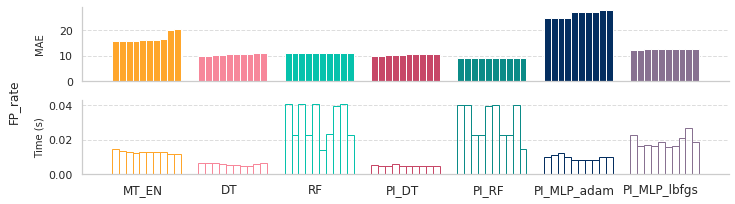


***** FP_speed *****


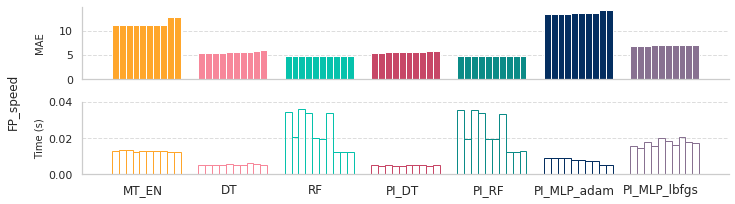


***** Int_rate *****


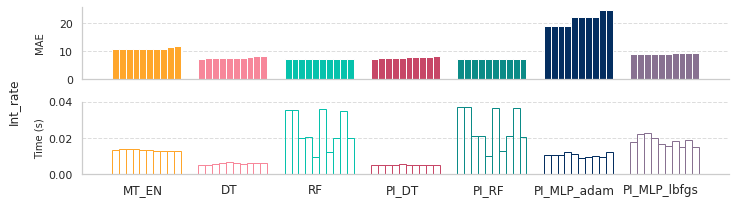


***** Int_speed *****


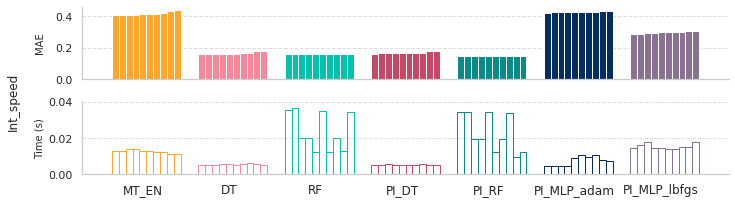

In [1]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_03_gridcv.pkl")

warnings.simplefilter(action="default")

pd.set_option("display.max_columns", None)  # show all columns when display
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

TOP_K = 10

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    configs = np.array([])
    prediction_performances = np.array([])
    prediction_times = np.array([])
    xticks = np.array([])

    for e_ind, est in enumerate(RFECV_ESTS):  # the mlp one will try both solvers
        
        grid_df = pd.DataFrame(grid[cat][e_ind].cv_results_)
        # works for both r2 and mae, because mae values are negative
        # for single evaluation metric, use: "mean_test_score"
        grid_df.sort_values(by=["mean_test_neg_mean_absolute_error"], inplace=True, ascending=False)
        #display(grid_df.head(2))

        # _is_view: True but _is_copy: None
        configs = np.append(configs, grid_df.iloc[:TOP_K, grid_df.columns.get_loc("params")])
        prediction_performances = np.append(
            prediction_performances,
            -grid_df.iloc[:TOP_K, grid_df.columns.get_loc("mean_test_neg_mean_absolute_error")] # negate
        )
        prediction_times = np.append(
            prediction_times, 
            grid_df.iloc[:TOP_K, grid_df.columns.get_loc("mean_score_time")]
        )
        xticks =  np.append(
            xticks, [i + (e_ind * TOP_K) for i in range(1, TOP_K + 1)]
        )

        #display(grid_df.iloc[:TOP_K, [grid_df.columns.get_loc("mean_test_neg_mean_absolute_error"), grid_df.columns.get_loc("mean_score_time"), grid_df.columns.get_loc("params")]])
    #display(configs)

    visualise.plot_tradeoff(
        prediction_performances, prediction_times, xticks, RFECV_ESTS, TOP_K, (10, 3), cat, save=True
    )

### Overfitting and Underfitting

**Note**: not included in the paper

We use the `validation_curve` function to plot the influence of `max_depth` on the training and validation scores of decision tress to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

We observe that a `max_depth` value between 15 and 20 provides a good fit across all suites, i.e. it does not underfit (low training and validation scores) or overfit (high
training score and low validation score).

/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.ut


***** FP_rate *****
Regressor: DecisionTreeRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


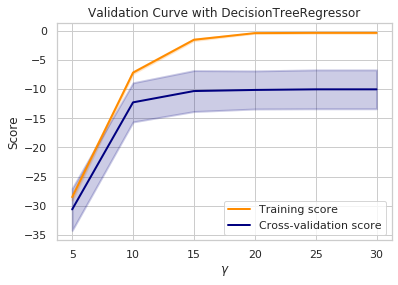

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-30.62112056 -12.26624049 -10.32799139 -10.13855106 -10.03447709
 -10.03447709]
[3.6030446  3.35596024 3.5102901  3.26612483 3.33416186 3.33416186]
Regressor: RandomForestRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


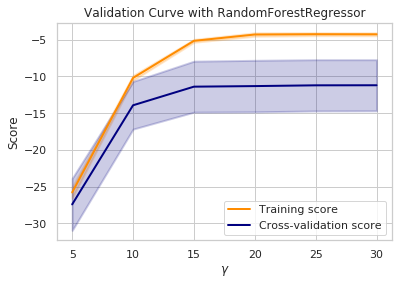

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-27.4126095  -13.92007448 -11.38560936 -11.30772285 -11.20312695
 -11.19366928]
[3.54257697 3.24507093 3.46851492 3.50761121 3.48711437 3.47765496]

***** FP_speed *****
Regressor: DecisionTreeRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


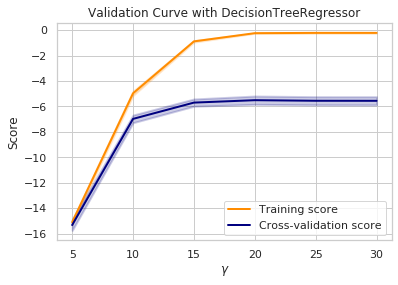

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-15.33220823  -6.98091845  -5.69984458  -5.5106701   -5.55596273
  -5.55955936]
[0.42175624 0.30178007 0.28539994 0.32618444 0.32093407 0.32323411]
Regressor: RandomForestRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


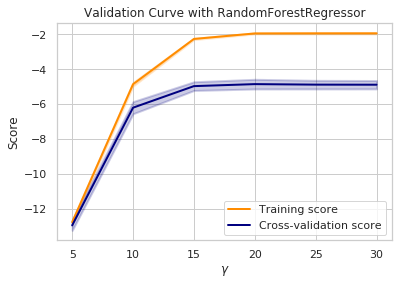

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-12.96639435  -6.20701283  -4.96935052  -4.85421342  -4.88368315
  -4.88780483]
[0.28866562 0.34935621 0.25020164 0.27753796 0.24645196 0.24040017]

***** Int_rate *****
Regressor: DecisionTreeRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


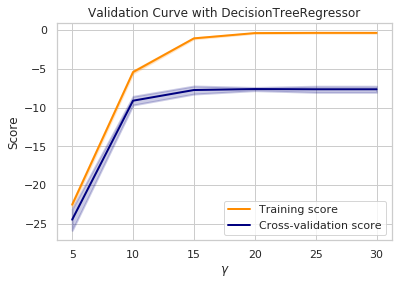

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-24.45098496  -9.10994054  -7.73584416  -7.61077036  -7.63955742
  -7.63955742]
[1.38939316 0.56181636 0.51905171 0.20309402 0.39573173 0.39573173]
Regressor: RandomForestRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


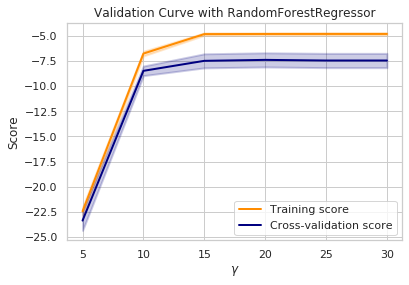

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-23.36527883  -8.48032587  -7.48532679  -7.39073936  -7.45386158
  -7.45386158]
[0.97858364 0.4766872  0.69895299 0.70332959 0.71058245 0.71058245]

***** Int_speed *****
Regressor: DecisionTreeRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


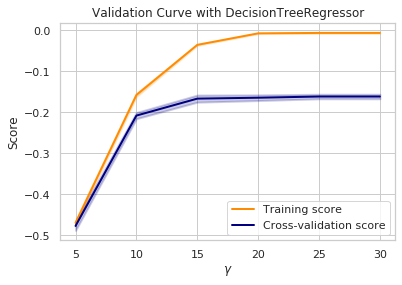

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-0.47723226 -0.20801886 -0.16666381 -0.16445882 -0.16153768 -0.16153768]
[0.01089193 0.00753521 0.00866111 0.00693474 0.00553507 0.00553507]
Regressor: RandomForestRegressor
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']


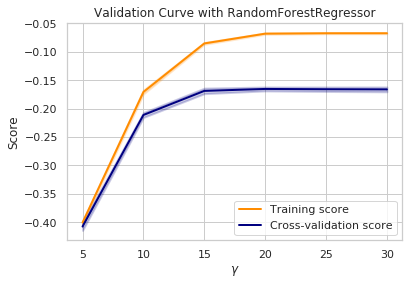

Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
[-0.40753609 -0.21108043 -0.16869353 -0.16527    -0.16578655 -0.16602823]
[0.00683027 0.00437051 0.00487397 0.00340728 0.00391222 0.00424914]


In [1]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_03_gridcv.pkl")

warnings.simplefilter(action="default")

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import validation_curve

over_under_ests = [fs_DT, fs_RF]

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    # different values for max_depth 
    max_depth_settings = [5, 10, 15, 20, 25, 30]

    for est in over_under_ests:
     
        # training_scores = []
        # validation_scores = []

        pipe.steps.pop(-1) # pop "eval"
        pipe.steps.pop(-1) # pop "rfe_mask_fs"

        evaluate = (
            est
            if not isinstance(est, eli5.sklearn.PermutationImportance)
            else est.estimator
        )
        
        print("Regressor:", colored(visualise.get_estimator_label(est), "green")) 

        pipe.steps.extend([
            ("rfe_mask_fs", feature_select.MaskFeatureSelect(rfe_manual_mask[cat][RFECV_ESTS.index(est)])),
            ("eval", evaluate)
        ])

        #display(pipe)
        print("Pipeline Steps: " + str(list(pipe.named_steps)))


        train_scores, valid_scores = validation_curve(
        pipe, train_X_df[cat], train_y_df[cat], param_name="eval__regressor__max_depth", param_range=max_depth_settings,
        scoring=GRIDCV_SCORING, cv=k_fold, n_jobs=-1)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)

        plt.title("Validation Curve with " + visualise.get_estimator_label(est))
        plt.xlabel(r"$\gamma$")
        plt.ylabel("Score")
        # plt.ylim(0.0, 1.1)
        lw = 2
        plt.plot(max_depth_settings, train_scores_mean, label="Training score",
                    color="darkorange", lw=lw)
        plt.fill_between(max_depth_settings, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2,
                        color="darkorange", lw=lw)
        plt.plot(max_depth_settings, valid_scores_mean, label="Cross-validation score",
                    color="navy", lw=lw)
        plt.fill_between(max_depth_settings, valid_scores_mean - valid_scores_std,
                        valid_scores_mean + valid_scores_std, alpha=0.2,
                        color="navy", lw=lw)
        plt.legend(loc="best")
        plt.show()
 ##########################


        print("Pipeline Steps: " + str(pipe.named_steps.keys()))
        # display pipeline
        set_config(display="diagram")
        #display(pipe)
        print(valid_scores_mean)
        print(valid_scores_std)



        # plt.plot(max_depth_settings, training_accuracy, label="training accuracy")
        # plt.plot(max_depth_settings, test_accuracy, label="test accuracy")
        # plt.ylabel("Accuracy")
        # plt.xlabel("max_depth")
        # plt.legend()
        # plt.title(str(pipe['eval'].regressor))
        # plt.show()

## 2.2 Learning Curves

We analyse the models’ performance as a function of the dataset size, i.e. the learning curves. Learning curves help to find out how much we can benefit from adding more training data.

**Note**: feature selection steps are removed, because with smaller datasets there will be more features with zero variance, which will in turn result in a slightly different set of selected features across datasets of different sizes.


***** FP_rate *****
Regressor: DecisionTreeRegressor(max_depth=20, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'eval']
Regressor: RandomForestRegressor(max_features=0.7, n_estimators=50, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'eval']

***** FP_speed *****
Regressor: DecisionTreeRegressor(max_depth=20, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'eval']
Regressor: RandomForestRegressor(max_features=0.7, n_estimators=50, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'eval']

***** Int_rate *****
Regressor: DecisionTreeRegressor(max_depth=20, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'eval']
Regressor: RandomForestRegressor(max_features=0.7, n_estimators=50, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'eva

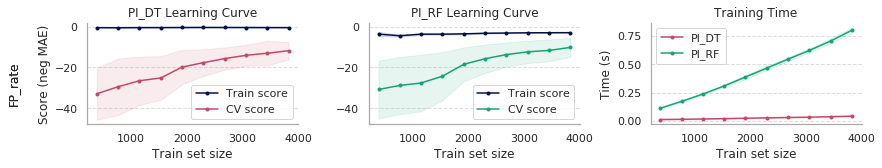

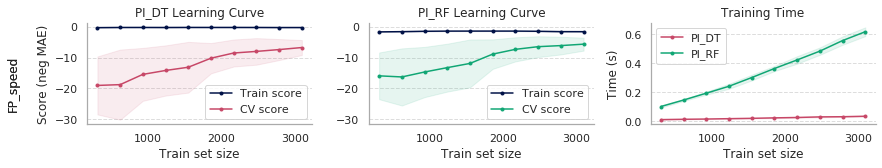

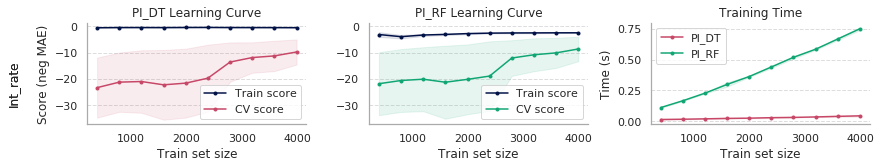

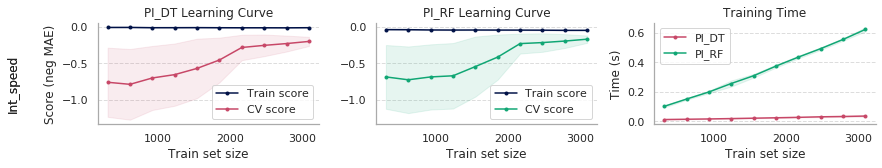

In [1]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_03_gridcv.pkl")

warnings.simplefilter(action="default")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

pipe.steps.pop(-1) # pop "eval"
pipe.steps.pop(-1) # pop "rfe_mask_fs"
pipe.steps.pop(-1) # pop "corr_fs"
pipe.steps.pop(-1) # pop "variance_fs"
#NOTE: we cannot add a debug here and check the X shape, because `learning_curve` clones the pipe/estimator, so we cannot easily trace it
# meaning that the fitting process is performed on the cloned estimators.
# But we can add a custom Debug_Verbose class that prints the shape for us
# It clearly shows that for some smaller training sets, the variance threshold results in one less feature

# from sklearn.base import BaseEstimator, TransformerMixin
# class Debug_Verbose(BaseEstimator, TransformerMixin):
#     """This class is designed to be used as an intermediate step in `Pipeline`s.
#     """

#     def __init__(self, rows=5):
#         """`rows`: number of rows of the transformed X to store for debugging purposes
#         """
#         self.rows = rows

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         self.X_head = X[: self.rows, :]
#         print(self.X_head.shape)
#         return X

# # remove variance 
# pipe.steps.extend([
#             ("corr_fs", feature_select.RemoveCorrFeatures(threshold=CLUSTER_TH)),
#             ("debug_verb", Debug_Verbose())
#         ])



learning_curve_ests = [fs_pi_dt, fs_pi_rf]


for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    fig, axes = plt.subplots(1, 3, figsize=(12, 2.5)) #sharey='row' - sharey=True shares y across all rows
    for i, est in enumerate(learning_curve_ests):
        # title = "Learning Curve: " + visualise.get_est_short_label(est)
        # cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
        lc_cv = KFold(n_splits=10, shuffle=False)

        evaluate = (
            est
            if not isinstance(est, eli5.sklearn.PermutationImportance)
            else est.estimator
        )
        
        if est == fs_pi_dt:
            evaluate.regressor.max_depth = 20
        elif est == fs_pi_rf:
            evaluate.regressor.n_estimators = 50
            evaluate.regressor.max_features = 0.7
        
        print("Regressor:", colored(evaluate.regressor, "green")) 

        pipe.steps.extend([
            #("rfe_mask_fs", feature_select.MaskFeatureSelect(rfe_manual_mask[cat][RFECV_ESTS.index(est)])),
            ("eval", evaluate)
        ])

        #display(pipe)
        print("Pipeline Steps: " + str(list(pipe.named_steps)))

        # visualise.plot_learning_curve(pipe, title, train_X_df[cat], train_y_df[cat], axes=axes[:, i], i=i,
        #                 cv=cv, scoring="neg_mean_absolute_error", n_jobs=1)
        visualise.plot_learning_curve(pipe, est, sorted_train_X_df[cat], sorted_train_y_df[cat], fig, axes, i, cat,
                        cv=lc_cv, scoring="neg_mean_absolute_error", n_jobs=1) 

        pipe.steps.pop(-1) # pop "eval"

    plt.tight_layout()
    SAVE = True
    if SAVE:
        fig.savefig(
            "plots/learning_curve/lc_" + cat + ".pdf",
            bbox_inches="tight",
            dpi=300,
        )

    else:
        plt.show()

## 2.3 Model Assessment

We estimate the generalisation error of the final models on new data, i.e. the test set, known as Model Assessment

- Full feature set vs. selected feature set

In [9]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_03_gridcv.pkl")

warnings.simplefilter(action="default")

pipe.steps.pop(-1) # pop "rfe_mask_fs"
pipe.steps.pop(-1) # pop "eval"

final_ests = [fs_EN, fs_pi_dt, fs_pi_rf, fs_pi_mlp_lbfgs]
final_regrs = {'all_feat': {}, 'sel_feat': {}}

def get_evaluate(est):
    evaluate = (
        est
        if not isinstance(est, eli5.sklearn.PermutationImportance)
        else est.estimator
    )
    
    if est == fs_EN:
        evaluate.regressor.alpha = 1e-4
        evaluate.regressor.l1_ratio = 0.75
        evaluate.regressor.max_iter = 5000
        evaluate.regressor.tol = 1e-4
    elif est == fs_pi_dt:
        evaluate.regressor.max_depth = 20
    elif est == fs_pi_rf:
        evaluate.regressor.n_estimators = 50
        evaluate.regressor.max_features = 0.7
    elif est == fs_pi_mlp_lbfgs:
        evaluate.regressor.hidden_layer_sizes = (50,)
        evaluate.regressor.solver = "lbfgs"
        evaluate.regressor.activation = "tanh"
        evaluate.regressor.max_iter = 10000
        evaluate.regressor.tol = 5e-4
    
    evaluate.regressor.n_jobs=1
    return evaluate

#####
# selected fetures
#####
print("##### Selected Features #####")
for est in final_ests:
    evaluate = get_evaluate(est)

    print("Regressor:", colored(evaluate.regressor, "green")) 

    pipe.steps.extend([
        ("rfe_mask_fs", feature_select.MaskFeatureSelect(rfe_manual_mask[cat][RFECV_ESTS.index(est)])),
        ("eval", evaluate)
    ])
    print("Pipeline Steps: " + str(list(pipe.named_steps)))
    est_key = visualise.get_est_short_label(est) 
    # format: final_regrs['sel_feat']['est_name']['FP_rate']
    final_regrs["sel_feat"][est_key] = {}

    for suite in suites:
        cat = suite["name"]
        print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

        final_model = model_regress.RegrModel(est_key, pipe)
        final_regrs["sel_feat"][est_key][cat] = final_model
        final_model.fit(train_X_df[cat], train_y_df[cat])
        final_model.predict(test_X_df[cat], test_y_df[cat])
        print(final_model)
    
    pipe.steps.pop(-1) # pop "eval"
    pipe.steps.pop(-1) # pop "rfe_mask_fs"

#####
# all features
#####
print("##### All Features #####")
pipe.steps.pop(-1) # pop "corr_fs"
pipe.steps.pop(-1) # pop "variance_fs"
for est in final_ests:
    evaluate = get_evaluate(est)

    print("Regressor:", colored(evaluate.regressor, "green")) 

    pipe.steps.extend([
        ("eval", evaluate)
    ])
    print("Pipeline Steps: " + str(list(pipe.named_steps)))
    est_key = visualise.get_est_short_label(est) 
    # format: final_regrs['sel_feat']['est_name']['FP_rate']
    final_regrs["all_feat"][est_key] = {}

    for suite in suites:
        cat = suite["name"]
        print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

        final_model = model_regress.RegrModel(est_key, pipe)
        final_regrs["all_feat"][est_key][cat] = final_model
        final_model.fit(train_X_df[cat], train_y_df[cat])
        final_model.predict(test_X_df[cat], test_y_df[cat])
        print(final_model)
    
    pipe.steps.pop(-1)

#####
# save the notebook session
dill.dump_session("pickles/regress_03_final_models.pkl")

##### Selected Features #####
Regressor: MultiTaskElasticNet(alpha=0.0001, l1_ratio=0.75, max_iter=5000, random_state=42)
Pipeline Steps: ['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval']

***** FP_rate *****
MT_EN
CustomTransformedTargetRegressor(regressor=MultiTaskElasticNet(alpha=0.0001,
                                                               l1_ratio=0.75,
                                                               max_iter=5000,
                                                               random_state=42),
                                 trans_y='log')
avg r2: 0.9673, avg mae: 19.1950, avg mape: 8.93, median mape: 8.10, train time: 1.4400, mean_pred time: 0.0057
n_features: 10
Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'rfe_mask_fs', 'eval'])
----------


***** FP_speed *****
MT_EN
CustomTransformedTargetRegressor(regressor=MultiTaskElasticNet(al

# 3. Final Comparison Plots

## 3.1 Full Set vs. Selected Set: R2, MAPE, and Latency

We use the results stored in `final_regrs` to create bar charts for the final models with the full set of 29 and selected set of 10 features. We compare the models in terms of R2, MAPE, and Prediction Time.

/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.ut

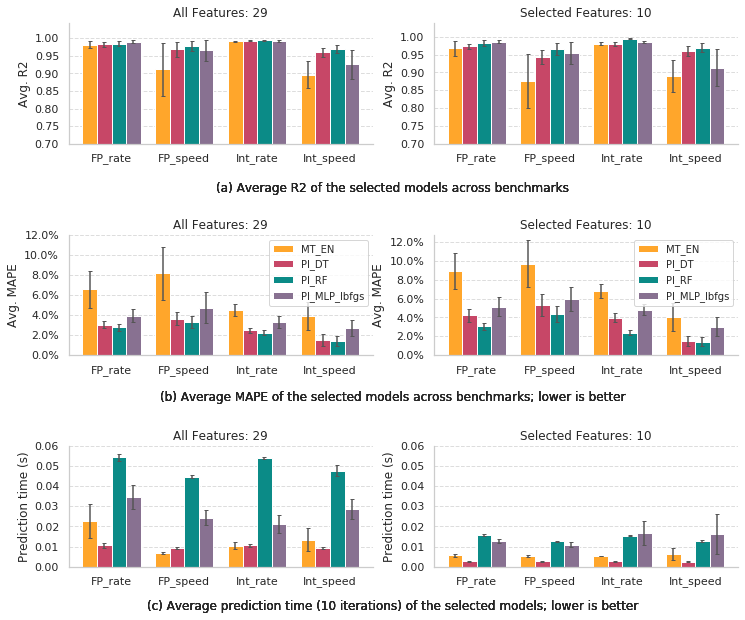

In [1]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session(("pickles/regress_03_final_models.pkl"))

warnings.simplefilter(action="default")

from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(3,2, figsize=(12, 10))

#####
# all features
#####
for e, est in enumerate(final_ests):
    est_key = visualise.get_est_short_label(est)
    r2_vals = {est_key: [], "n_feat": None}
    r2_stds = {est_key: []}
    mape_vals = {est_key: [], "n_feat": None}
    mape_stds = {est_key: []}
    pred_times = {est_key: [], "n_feat": None}
    pred_stds = {est_key: []}


    for s, suite in enumerate(suites):
        cat = suite['name']
        # assert len(list(X_df[cat])) == len(all_features[cat]), 'This is not with all features!'
        # num_f[cat] = str(len(all_features[cat])) + ' features'
        #num_f[cat] = str(len(list(X_df[cat]))) + ' features'
        r2_vals[est_key].append(final_regrs["all_feat"][est_key][cat].avg_r2)
        r2_stds[est_key].append(final_regrs["all_feat"][est_key][cat].std_r2)
        r2_vals["n_feat"] = str(final_regrs["all_feat"][est_key][cat].n_features)
        mape_vals[est_key].append(final_regrs["all_feat"][est_key][cat].avg_mape)
        mape_stds[est_key].append(final_regrs["all_feat"][est_key][cat].std_mape)
        mape_vals["n_feat"] = str(final_regrs["all_feat"][est_key][cat].n_features)

        pred_times[est_key].append(final_regrs["all_feat"][est_key][cat].mean_pred_time)
        pred_stds[est_key].append(final_regrs["all_feat"][est_key][cat].std_pred_time)
        pred_times["n_feat"] = str(final_regrs["all_feat"][est_key][cat].n_features)

    
    ind = np.arange(4)    # the x locations for the groups
    w = 0.2         # the width of the bars
    pos = [ind-(2*w),ind-(1*w), ind, ind+(1*w)]

    p0 = axes[0][0].bar(pos[e], r2_vals[est_key], w, bottom=0, color=visualise.get_bar_color(RFECV_ESTS.index(est)), label=est_key, yerr = r2_stds[est_key], error_kw=dict(capsize=2, capthick=1, ecolor="#555555"))
    axes[0][0].set_ylabel('Avg. R2')
    axes[0][0].set_ylim(bottom=0.7)
    axes[0][0].set_yticks([0.70,0.75,0.80,0.85,0.90,0.95,1.00])
    axes[0][0].set_title("All Features: " + r2_vals["n_feat"])

    p1 = axes[1][0].bar(pos[e], mape_vals[est_key], w, bottom=0, color=visualise.get_bar_color(RFECV_ESTS.index(est)), label=est_key, yerr = mape_stds[est_key], error_kw=dict(capsize=2, capthick=1, ecolor="#555555"))
    axes[1][0].set_ylabel('Avg. MAPE')
    axes[1][0].legend(loc='upper right', frameon=True, fontsize=10)
    axes[1][0].set_yticks([0,2,4,6,8,10,12])
    axes[1][0].yaxis.set_major_formatter(PercentFormatter())
    axes[1][0].set_title("All Features: " + mape_vals["n_feat"])

    p2 = axes[2][0].bar(pos[e], pred_times[est_key], w, bottom=0, color=visualise.get_bar_color(RFECV_ESTS.index(est)), label=est_key, yerr = pred_stds[est_key], error_kw=dict(capsize=2, capthick=1, ecolor="#555555"))
    axes[2][0].set_ylabel('Prediction time (s)')
    axes[2][0].set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
    axes[2][0].set_title("All Features: " + pred_times["n_feat"])
    

    for i in range(3):
        axes[i][0].spines['right'].set_visible(False)
        axes[i][0].spines['top'].set_visible(False)
        axes[i][0].set_xticks(ind - w / 2)
        axes[i][0].set_xticklabels([suite['name'] for suite in suites], fontsize=11)
        axes[i][0].grid(False)
        axes[i][0].grid(axis="y", color="#dddddd", ls="--")

# plt.tight_layout()
# # plt.show()
# plt.savefig(
#     "plots/model_selection/final_" + r2_vals["n_feat"] + "feat.pdf",
#     bbox_inches="tight",
#     dpi=300,
# )

#####
# Selected features
#####

for e, est in enumerate(final_ests):
    est_key = visualise.get_est_short_label(est)
    r2_vals = {est_key: [], "n_feat": None}
    r2_stds = {est_key: []}
    mape_vals = {est_key: [], "n_feat": None}
    mape_stds = {est_key: []}
    pred_times = {est_key: [], "n_feat": None}
    pred_stds = {est_key: []}


    for s, suite in enumerate(suites):
        cat = suite['name']
        # assert len(list(X_df[cat])) == len(all_features[cat]), 'This is not with all features!'
        # num_f[cat] = str(len(all_features[cat])) + ' features'
        #num_f[cat] = str(len(list(X_df[cat]))) + ' features'
        r2_vals[est_key].append(final_regrs["sel_feat"][est_key][cat].avg_r2)
        r2_stds[est_key].append(final_regrs["sel_feat"][est_key][cat].std_r2)
        r2_vals["n_feat"] = str(final_regrs["sel_feat"][est_key][cat].n_features)
        mape_vals[est_key].append(final_regrs["sel_feat"][est_key][cat].avg_mape)
        mape_stds[est_key].append(final_regrs["sel_feat"][est_key][cat].std_mape)
        mape_vals["n_feat"] = str(final_regrs["sel_feat"][est_key][cat].n_features)

        pred_times[est_key].append(final_regrs["sel_feat"][est_key][cat].mean_pred_time)
        pred_stds[est_key].append(final_regrs["sel_feat"][est_key][cat].std_pred_time)
        pred_times["n_feat"] = str(final_regrs["sel_feat"][est_key][cat].n_features)

    
    ind = np.arange(4)    # the x locations for the groups
    w = 0.2         # the width of the bars
    pos = [ind-(2*w),ind-(1*w), ind, ind+(1*w)]

    p0 = axes[0][1].bar(pos[e], r2_vals[est_key], w, bottom=0, color=visualise.get_bar_color(RFECV_ESTS.index(est)), label=est_key, yerr = r2_stds[est_key], error_kw=dict(capsize=2, capthick=1, ecolor="#555555"))
    axes[0][1].set_ylabel('Avg. R2')
    axes[0][1].set_ylim(bottom=0.70)
    axes[0][1].set_yticks([0.70,0.75,0.80,0.85,0.90,0.95,1.00])
    axes[0][1].set_title("Selected Features: " + r2_vals["n_feat"])

    p1 = axes[1][1].bar(pos[e], mape_vals[est_key], w, bottom=0, color=visualise.get_bar_color(RFECV_ESTS.index(est)), label=est_key, yerr = mape_stds[est_key], error_kw=dict(capsize=2, capthick=1, ecolor="#555555"))
    axes[1][1].set_ylabel('Avg. MAPE')
    axes[1][1].legend(loc='upper right', frameon=True, fontsize=10)
    axes[1][1].set_yticks([0,2,4,6,8,10,12])
    axes[1][1].yaxis.set_major_formatter(PercentFormatter())
    axes[1][1].set_title("Selected Features: " + mape_vals["n_feat"])

    p2 = axes[2][1].bar(pos[e], pred_times[est_key], w, bottom=0, color=visualise.get_bar_color(RFECV_ESTS.index(est)), label=est_key, yerr = pred_stds[est_key], error_kw=dict(capsize=2, capthick=1, ecolor="#555555"))
    axes[2][1].set_ylabel('Prediction time (s)')
    axes[2][1].set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
    axes[2][1].set_title("Selected Features: " + pred_times["n_feat"])

    for i in range(3):
        axes[i][1].spines['right'].set_visible(False)
        axes[i][1].spines['top'].set_visible(False)
        axes[i][1].set_xticks(ind - w / 2)
        axes[i][1].set_xticklabels([suite['name'] for suite in suites], fontsize=11)
        axes[i][1].grid(False)
        axes[i][1].grid(axis="y", color="#dddddd", ls="--")

    # Adjust vertical_spacing = 0.75 * axes_height
    plt.subplots_adjust(hspace=0.75)
    plt.figtext(0.5, 0.65, '(a) Average R2 of the selected models across benchmarks', ha='center', va='center')
    plt.figtext(0.5, 0.36, '(b) Average MAPE of the selected models across benchmarks; lower is better', ha='center', va='center')
    plt.figtext(0.5, 0.07, '(c) Average prediction time (10 iterations) of the selected models; lower is better', ha='center', va='center')

        # print(r2_vals)
        # print(mape_vals)


# plt.tight_layout() # hspace is set
plt.savefig(
    "plots/model_selection/final_comparison.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

## 3.2 Radar Plots

We show MAPE values of final models with the full set of 29 and selected set of 10 features for all benchmarks

In [1]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session(("pickles/regress_03_final_models.pkl"))

from plotly.subplots import make_subplots
import plotly.graph_objects as go

colors = ['rgba(255, 195, 36, 0.5)', 'rgba(233, 11, 48, 0.5)', 'rgba(8, 175, 63, 0.5)', 'rgba(158, 130, 216, 0.5)']
edges = ['rgba(255, 195, 36, 1)', 'rgba(233, 11, 48, 1)', 'rgba(8, 175, 63, 1)', 'rgba(158, 130, 216, 1)']


for feat_mod in final_regrs:
      fig = make_subplots(rows=2, cols=2, specs=[[{"type": "polar"}, {"type": "polar"}],
           [{"type": "polar"}, {"type": "polar"}]], subplot_titles=tuple(suite["name"] for suite in suites))
      for s, suite in enumerate(suites):
            cat = suite["name"]
            benchmarks = suite["benchmarks"]
            #print(category)

            benchmarks = [*benchmarks, benchmarks[0]]

            for m, model in enumerate(final_regrs[feat_mod]):
                  r = final_regrs[feat_mod][model][cat].mapes
                  fig.add_trace(go.Scatterpolar(
                        r=[*r,r[0]],
                        theta=benchmarks,
                        fill='toself',
                        name=model,
                        fillcolor=colors[m],
                        marker=dict(color=edges[m], size=4),
                        showlegend= not(s),
                  ), row=int(s/2)+1, col=s%2+1)

      fig.update_layout(
            autosize=False,
            width=800,
            height=550,
            polar=dict(
            radialaxis=dict(
                  visible=True,
                  range=[0, 16]
            )),
            polar2=dict(
            radialaxis=dict(
                  visible=True,
                  range=[0, 16]
            )),
            polar3=dict(
            radialaxis=dict(
                  visible=True,
                  range=[0, 16]
            )),
            polar4=dict(
            radialaxis=dict(
                  visible=True,
                  range=[0, 16],
            )),
            legend=dict(
                  x=0.44,
                  y=0.6,
                  traceorder='normal',
                  font=dict(
                        size=10,),
                  bordercolor="#ccc",
                  borderwidth=1
            ),
            margin=dict(l=0,r=0,b=20,t=40),
            title={
                  'text': ('All Features: 29' if feat_mod=='all_feat' else 'Selected Features: 10') + (
                  ' - MAPE values (%) of all benchmarks'),
                  'x':0.5,
                  'y':0.47,
                  'font_size': 12,
                  'xanchor': 'center',
                  'yanchor': 'top'
            },
            template='seaborn' 
            
      )
      fig.update_annotations(yshift=12, font_size=12)
      fig.update_polars(angularaxis_tickfont_size=10, radialaxis_tickfont_size=10)

      fig.write_image( "plots/model_selection/radar_" + feat_mod + ".pdf")
      fig.show()

/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.ut